### Dependencies

In [1]:
# Update conda
!conda update -n base -c defaults conda

# Install dependencies
!conda install --yes --file ../requirements.txt

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



### Imports

In [2]:
# Torch
import torch

# Torch Vision
import torchvision

# Path
from pathlib import Path

# Matplot
import matplotlib.pyplot as pp

# Reduce
from functools import reduce

### GPU

In [3]:
# Check if GPU is available
try:
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
except:
    print('CPU')

GeForce MX150


### Pre-processing <a name="pre-processing"></a>

The train dataset is loaded, resized, transformed to tensor and normalized. Data augmentation is applied. The resize and normalization is done to enable the usage of pre-trained models weights.

The validation dataset is loaded, resized and normalized.

The test dataset is a split of the validation dataset, 80% from images are used to validation and 20% to test.

In [4]:
def load(path = None, transform = None):
    '''
        Load dataset
        
        Parameters
        ----------
        
        path: str
            Dataset path
        
        transform: torchvision.transforms
            Transform function
            
        Usage
        -----
        
        >>> load(path = '')
        
        Return
        ------
        
        Image Folder object
        
        References
        ----------
        
        https://pytorch.org/docs/stable/torchvision/transforms.html
        
        https://pytorch.org/docs/stable/data.html
    '''
    
    pth = Path(path)
    
    if not pth.exists() or not pth.is_dir():
        raise Exception('Incompatible path')
    
    dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform=transform
    )
    
    return dataset


def plot(axe = None, images = None, cmap = 'gray', title = '', color = False):
    '''
        Plot images
        
        Parameters
        ----------
        
        axe: matplotlib.pyplot.subplots
            Matplot buffer
        
        images: torch.tensor
            Tensor matrix
            
        cmap: str
            Color map
        
        title: str
            Matrix title
        
        color: bool
            RGB images
            
        Usage
        -----
        
        Gray
        
        >>> figure, axe = pp.subplots(nrows=2, ncols=2, figsize=(2, 2))
        >>>
        >>> plot(axe, [torch.randn((4, 4)) for image in range(0, 4)])
        
        RGB
        
        >>> figure, axe = pp.subplots(nrows=2, ncols=2, figsize=(2, 2))
        >>>
        >>> plot(axe, [torch.randn((4, 4, 3)) for image in range(0, 4)], color = True)
        
        Return
        ------
        
        None
        
        References
        ----------
        
        https://matplotlib.org/examples/color/colormaps_reference.html
    '''
    
    count = 0
    
    if len(axe.shape) == 1:
        for col in range(axe.shape[0]):
            if color:
                axe[col].imshow(images[count].numpy().transpose((1, 2, 0)))
            else:
                axe[col].imshow(images[count].numpy().squeeze(), cmap=cmap)
            
            axe[col].axis('off')
            
            if title:
                axe[col].set_title(title)
            
            count += 1
        
        return
    
    for row in range(axe.shape[0]):
        for col in range(axe.shape[1]):
            if color:
                axe[row, col].imshow(images[count].numpy().transpose((1, 2, 0)))
            else:
                axe[row, col].imshow(images[count].numpy().squeeze(), cmap=cmap)
            
            axe[row, col].axis('off')
            
            if title:
                axe[row, col].set_title(title)
            
            count += 1

In [5]:
# Train dataset
height_train, width_train = 224, 224

batch_size_train = 102

num_workers_train = 0

path_train = '../data/train'

# Default transform
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = [
    torchvision.transforms.Resize((height_train, width_train)),
    torchvision.transforms.ToTensor(),
    normalize
]

# Train 1
train1 = load(path=path_train, transform=torchvision.transforms.Compose(transform_train))

# Train 2
_train2 = transform_train.copy()

_train2.insert(1, torchvision.transforms.RandomRotation((30, 360)))

train2 = load(path=path_train, transform=torchvision.transforms.Compose(_train2))

# Train 3
_train3 = transform_train.copy()

_train3.insert(1, torchvision.transforms.ColorJitter(brightness = 2.0, hue = 0.5, saturation = 0.5))

train3 = load(path=path_train, transform=torchvision.transforms.Compose(_train3))

# Train 4
_train4 = transform_train.copy()

_train4.pop(0)

_train4.insert(0, torchvision.transforms.RandomCrop(size=(height_train, width_train)))

train4 = load(path=path_train, transform=torchvision.transforms.Compose(_train4))

# Train 5
_train5 = transform_train.copy()

_train5.insert(1, torchvision.transforms.RandomHorizontalFlip(p = 1.0))

_train5.insert(2, torchvision.transforms.RandomVerticalFlip(p = 1.0))

train5 = load(path=path_train, transform=torchvision.transforms.Compose(_train5))

# Concat datasets
train_vector = [
    {'title': 'Original', 'data': train1},
    {'title': 'Rotation', 'data': train2},
    {'title': 'Brightness', 'data': train3},
    {'title': 'Crop', 'data': train4},
    {'title': 'Flip', 'data': train5},
]

for obj in train_vector:
    obj['data'] = torch.utils.data.DataLoader(
        obj['data'],
        batch_size = batch_size_train,
        num_workers = num_workers_train,
        shuffle = True
    )

print(reduce(lambda start, length: start + length, [len(obj['data'].dataset) for obj in train_vector]))

32760


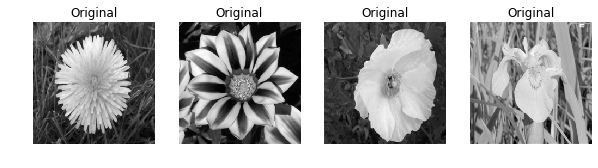

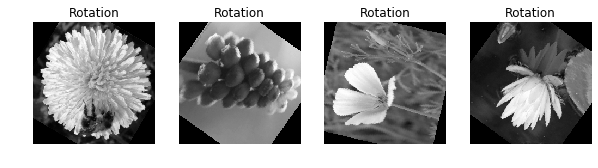

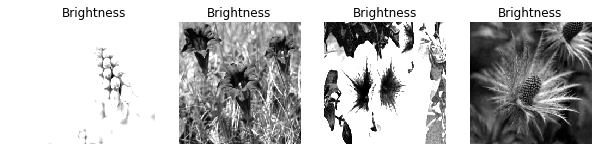

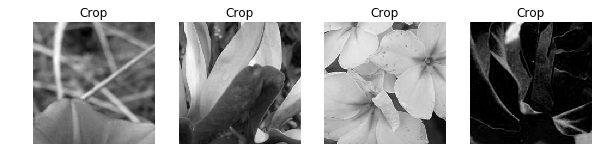

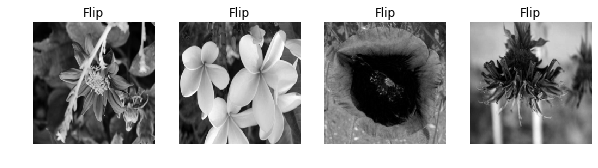

In [6]:
# Plot train dataset
%matplotlib inline

for obj in train_vector:
    # Get epoch
    images_train, labels_train = iter(obj['data']).next()
    
    # Create buffer
    figure, axe = pp.subplots(nrows=1, ncols=4, figsize=(10, 10))
     
    # Plot images
    plot(axe = axe, images = images_train[:, 1], title = obj['title'])

In [7]:
# Validation dataset
height_validation, width_validation = 224, 224

batch_size_validation = 102

num_workers_validation = 0

path_validation = '../data/valid'

# Default transform
transform_validation = [
    torchvision.transforms.Resize((height_validation, width_validation)),
    torchvision.transforms.ToTensor(),
    normalize
]

# Validation
validation = torch.utils.data.DataLoader(
    load(path = path_validation, transform=torchvision.transforms.Compose(transform_validation)),
    batch_size = batch_size_validation,
    num_workers = num_workers_validation,
    shuffle = True
)

print(len(validation.dataset))

818


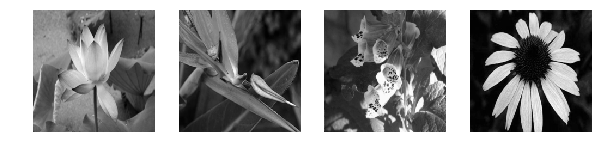

In [8]:
# Plot validation dataset
%matplotlib inline

images_validation, labels_validation = iter(validation).next()

# Create buffer
figure, axe = pp.subplots(nrows=1, ncols=4, figsize=(10, 10))

# Plot images
plot(axe = axe, images = images_validation[:, 1])

In [9]:
# Test dataset
validation_size = int(0.8 * len(validation.dataset))

test_size = int(len(validation.dataset) - validation_size)

validation, test = torch.utils.data.random_split(validation.dataset, [validation_size, test_size])

print(len(validation), len(test))

654 164


### Models

The usage of pre-trained models require some transformations, see the [documentation](https://pytorch.org/docs/stable/torchvision/models.html#torchvision-models) for more details. The the freezed layers can be found on `~/.torch/models`.

To architecture references, read the papers [rethinking the inception architecture for computer vision](https://arxiv.org/abs/1512.00567) and [deep residual learning for image recognition](https://arxiv.org/abs/1512.03385) ([talk](https://www.youtube.com/watch?v=C6tLw-rPQ2o)).

#### Resnet 18

In [10]:
# Create model
resnet18 = torchvision.models.resnet18(pretrained=True)

In [11]:
# Adapt the fully connected layer to the dataset
resnet18.fc = torch.nn.Linear(512, 102, bias=True)

In [12]:
# Process model using GPU
if torch.cuda.is_available:
    resnet18.cuda()
    
    print('CUDA')
else:
    print('CPU')

CUDA


In [ ]:
# Train
resnet18.train()

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params = resnet18.parameters(),
    lr = 0.001
)

for obj in train_vector:
    for epoch, (images, labels) in enumerate(obj['data']):
        # Process data using GPU
        if torch.cuda.is_available:
            images, labels = images.cuda(), labels.cuda()
            
        # Set the gradient to zero
        optimizer.zero_grad()
        
        # Compute the output
        output = resnet18(images)
        
        # Compute the loss
        loss = criterion(output, labels)
        
        # Retro propagate
        loss.backward()
        
        optimizer.step()
        
        print('Epoch [{1}][{0}]: {2} loss'.format(obj['title'].lower(), epoch, loss))